## Optimizing Matrix Multiplication

This demonstration shows the following works done with using this compiler:

- Lowering and optimizing custom-defined matmul IR from high-level to low-level
- Generating matmul code for specified target backend (e.g., C++) and JIT compiling the code for runtime execution
- Performance benchmark of the following three implementations:
  - Naive kernel
  - Compiler-pass optimized kernel
  - BLAS

Below figure shows the performance benchmark result for (1024 x 1024) * (1024 x 1024) matmul.

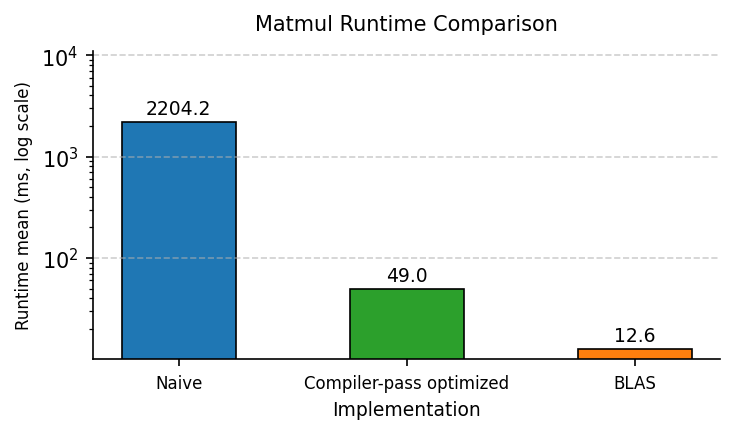

### 1. Parsing Frontend instructions

In [1]:
import src.frontend as fe

fe_ir: fe.Reduction = fe.parse("[1024, 1024] @ [1024, 1024]")

print("-------- Step 0: Raw Instruction -------")
print(fe_ir)

-------- Step 0: Raw Instruction -------
[1024, 1024] @ [1024, 1024]



### 2. Lowering Front-end to Middle-end Representations

##### 2-1. Legalizing Front-end instruction into legalized IR

In [2]:
import src.middleend as me

print("-------- Step 1: Naive Legalized --------")
me_ir: me.Reduction = fe_ir.legalize()

# creating copy for benchmark
me_ir_naive = me_ir.copy()
print(me_ir_naive)

-------- Step 1: Naive Legalized --------
@IR.mm
for (m in 0..1024) {
  for (n in 0..1024) {
    for (k in 0..1024) reduction {  // reduction over k
      %a_1 = load A[m, k]
      %b_1 = load B[k, n]
      %mul_1 = mul %a_1, %b_1
      accumul %mul_1, C[m, n]
    }
  }
}



##### 2-2. Applying block-tiling compiler pass for enhanced cache locality

In [3]:
me_ir.tile(tile_sizes={'m': 256, 'n': 256, 'k': 256})
print("-------- Step 2: Tiling pass applied --------")
print(me_ir)

-------- Step 2: Tiling pass applied --------
@IR.mm
for (m_blk in 0..1024//256) {
  for (m_inner in 0..256) {
    for (n_blk in 0..1024//256) {
      for (n_inner in 0..256) {
        for (k_blk in 0..1024//256) {
          for (k_inner in 0..256) reduction {  // reduction over k_inner
            %a_1 = load A[(m_blk * 256 + m_inner), (k_blk * 256 + k_inner)]
            %b_1 = load B[(k_blk * 256 + k_inner), (n_blk * 256 + n_inner)]
            %mul_1 = mul %a_1, %b_1
            accumul %mul_1, C[(m_blk * 256 + m_inner), (n_blk * 256 + n_inner)]
          }
        }
      }
    }
  }
}



##### 2-3. Double-tiling for utilizing CPU cache-hierarchy

In [4]:
me_ir.tile(tile_sizes={'m_inner': 32, 'k_inner': 32, 'n_inner': 128})
print("-------- Step 3: Double-tiling pass applied --------")
print(me_ir)

-------- Step 3: Double-tiling pass applied --------
@IR.mm
for (m_blk in 0..1024//256) {
  for (m_inner_blk in 0..256//32) {
    for (m_inner_inner in 0..32) {
      for (n_blk in 0..1024//256) {
        for (n_inner_blk in 0..256//128) {
          for (n_inner_inner in 0..128) {
            for (k_blk in 0..1024//256) {
              for (k_inner_blk in 0..256//32) {
                for (k_inner_inner in 0..32) reduction {  // reduction over k_inner_inner
                  %a_1 = load A[(m_blk * 256 + (m_inner_blk * 32 + m_inner_inner)), (k_blk * 256 + (k_inner_blk * 32 + k_inner_inner))]
                  %b_1 = load B[(k_blk * 256 + (k_inner_blk * 32 + k_inner_inner)), (n_blk * 256 + (n_inner_blk * 128 + n_inner_inner))]
                  %mul_1 = mul %a_1, %b_1
                  accumul %mul_1, C[(m_blk * 256 + (m_inner_blk * 32 + m_inner_inner)), (n_blk * 256 + (n_inner_blk * 128 + n_inner_inner))]
                }
              }
            }
          }
        }
      }
    

##### 2-4. Reordering loop for virtual transpose (enhanced access pattern) and promoting invariants by loop hoisting

In [5]:
me_ir.reorder([
    'm_blk','n_blk','k_blk',
    'm_inner_blk','n_inner_blk','k_inner_blk',
    'm_inner_inner', 'k_inner_inner', 'n_inner_inner',
])
print(me_ir)

me_ir.promote_invariants("n_inner_inner")
print("-------- Step 4: Hoisting promotion --------")
print(me_ir)

@IR.mm
for (m_blk in 0..1024//256) {
  for (n_blk in 0..1024//256) {
    for (k_blk in 0..1024//256) {
      for (m_inner_blk in 0..256//32) {
        for (n_inner_blk in 0..256//128) {
          for (k_inner_blk in 0..256//32) {
            for (m_inner_inner in 0..32) {
              for (k_inner_inner in 0..32) reduction {  // reduction over k_inner_inner
                for (n_inner_inner in 0..128) {
                  %a_1 = load A[(m_blk * 256 + (m_inner_blk * 32 + m_inner_inner)), (k_blk * 256 + (k_inner_blk * 32 + k_inner_inner))]
                  %b_1 = load B[(k_blk * 256 + (k_inner_blk * 32 + k_inner_inner)), (n_blk * 256 + (n_inner_blk * 128 + n_inner_inner))]
                  %mul_1 = mul %a_1, %b_1
                  accumul %mul_1, C[(m_blk * 256 + (m_inner_blk * 32 + m_inner_inner)), (n_blk * 256 + (n_inner_blk * 128 + n_inner_inner))]
                }
              }
            }
          }
        }
      }
    }
  }
}

[Promotion] Hoisting A outside n_inner_inner

(Following compiler pass features are currently under dev.)

In [6]:
# me_ir.vectorize('n_inner', 8)  // under dev
# print("-------- Step 5: After Vectorization --------")
# print(me_ir)

# me_ir.unroll('k_inner', 4)  // under dev
# print("-------- Step 6: After Unrolling --------")
# print(me_ir)

##### 2-5 Emitting target backend specific code for JIT compilation

In [7]:
from src.compile import emit
from src.constants import Targets

naive_src = emit(me_ir_naive, target=Targets.C, name="mm_naive")
opt_src = emit(me_ir, target=Targets.C, name="mm_opt")

print(naive_src)
print(opt_src)

// Compiled C++ code of legalized op: 'mm_naive'
void mm_naive(const float* A, const float* B, float* C) {
  for (size_t m = 0; m < 1024; ++m) {
    for (size_t n = 0; n < 1024; ++n) {
      for (size_t k = 0; k < 1024; ++k) {  // reduction over k
        float a_1 = A[(m) * (1024) + k];
        float b_1 = B[(k) * (1024) + n];
        float mul_1 = a_1 * b_1;
        C[(m) * (1024) + n] += mul_1;
      }
    }
  }
}

// Compiled C++ code of legalized op: 'mm_opt'
void mm_opt(const float* A, const float* B, float* C) {
  for (size_t m_blk = 0; m_blk < 4; ++m_blk) {
    for (size_t n_blk = 0; n_blk < 4; ++n_blk) {
      for (size_t k_blk = 0; k_blk < 4; ++k_blk) {
        for (size_t m_inner_blk = 0; m_inner_blk < 8; ++m_inner_blk) {
          for (size_t n_inner_blk = 0; n_inner_blk < 2; ++n_inner_blk) {
            for (size_t k_inner_blk = 0; k_inner_blk < 8; ++k_inner_blk) {
              for (size_t m_inner_inner = 0; m_inner_inner < 32; ++m_inner_inner) {
                for (size

### 3. JIT compiling emitted source into target backend binary

In [8]:
from src.compile import Runtime

mod, script = Runtime.jit([naive_src, opt_src])

# generated C++ code
print(script)

[1/2] /usr/bin/clang++ -MMD -MF mod.o.d -DTORCH_EXTENSION_NAME=mod -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/honggyu/miniconda3/envs/ai/lib/python3.12/site-packages/torch/include -isystem /home/honggyu/miniconda3/envs/ai/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /home/honggyu/miniconda3/envs/ai/include/python3.12 -fPIC -std=c++17 -O3 -march=native -flto -c /home/honggyu/workspace/compiler/output/mod.cpp -o mod.o 
[2/2] /usr/bin/clang++ mod.o -shared -flto -L/home/honggyu/miniconda3/envs/ai/lib/python3.12/site-packages/torch/lib -lc10 -ltorch_cpu -ltorch -ltorch_python -o mod.so
// This code is auto-generated.
#include <torch/extension.h>


// Compiled C++ code of legalized op: 'mm_naive'
void mm_naive(const float* A, const float* B, float* C) {
  for (size_t m = 0; m < 1024; ++m) {
    for (size_t n = 0; n < 1024; ++n) {
      for (size_t k = 0; 

### 4. Testing Computation & Performance Benchmarking

In [10]:
import torch
torch.set_num_threads(1)

a = torch.randn(1024, 1024)
b = torch.randn(1024, 1024)

torch_out = torch.mm(a, b)
naive_out = mod.mm_naive(a, b)
opt_out = mod.mm_opt(a, b)

# Check computation result
print(torch.allclose(torch_out, naive_out, atol=1e-4))
print(torch.allclose(torch_out, opt_out, atol=1e-4))

True
True


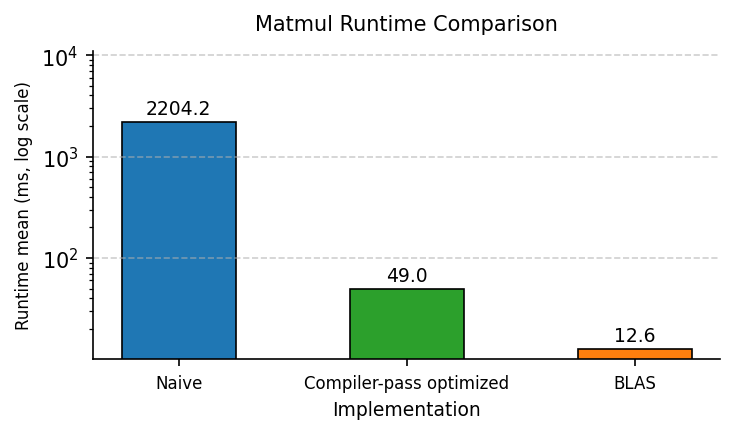

In [11]:
from triton.testing import do_bench

from utils import perf_plot

torch_res = do_bench(lambda : torch.mm(a, b))
naive_res = do_bench(lambda : mod.mm_naive(a, b))
opt_res = do_bench(lambda : mod.mm_opt(a, b))

perf_plot(
    labels=["Naive", "Compiler-pass optimized", "BLAS"],
    values=[naive_res, opt_res, torch_res]
)